https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba

# Data Preparation.

In [1]:
import re 
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import binarize
np.random.seed(5)

In [2]:
test_text = '''where are you?
is she in mexico?
i am in greece.
she is in mexico.
is she in england?
'''

train_text = '''are you still here?
where are you?
he is in mexico.
are you tired?
i am tired.
are you in england?
were you in mexico?
is he in greece?
were you in england?
are you in mexico?
i am in mexico.
are you still in mexico? 
are you in greece again?
she is in england.
he is tired.
am i in mexico?
how are you?
'''

In [3]:
def tokenise(s):
    return [i for i in re.sub('([.?])', ' \g<1>', s).strip().split(' ') if i]

In [4]:
def one_hot(y, classes):
    onehot = np.zeros((len(y), classes)) # creates matrix of ? rows, ? columns 
    
    # Iterate through y and update onehot's column to 1 based on the class
    # y [0, 1, 4, 3, 2]
    for i, v in enumerate(y):
        onehot[i][v] = 1
    return onehot

In [5]:
vocab = list(set([token for token in re.sub('([.?])', ' \g<1>', train_text)
             .replace(' ', '\n').strip().split('\n') if token]))
vocab += ['<BOS>', '<EOS>', '<PAD>']
vocab.sort()

In [6]:
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

In [7]:
pad = max([len(tokenise(i)) for i in train_text.split('\n')]) + 1
train_sentences = []
for line in train_text.strip().split('\n'):
        tokens = tokenise(line)
        padded = ['<BOS>'] + tokens + ['<EOS>'] + ['<PAD>'] * (pad - len(tokens))
        train_sentences.append([word2idx[token] for token in padded])

In [8]:
x = []
y = []
for sentence in train_sentences:
    for i in range(pad - 2):
            x.append([sentence[i], sentence[i+1]])
            y.append(sentence[i+2])
X = np.array(x)
Y = np.array(y)
Yo = one_hot(Y, len(vocab))

In [9]:
test_sentences = []
for line in test_text.strip().split('\n'):
        tokens = tokenise(line)
        padded = ['<BOS>'] + tokens + ['<EOS>'] + ['<PAD>'] * (pad - len(tokens))
        test_sentences.append([word2idx[token] for token in padded])

In [10]:
x_test = []
y_test = []
for sentence in test_sentences:
    for i in range(pad - 2):
            x_test.append([sentence[i], sentence[i+1]])
            y_test.append(sentence[i+2])
X_test = np.array(x_test)
Y_test = np.array(y_test)
Yo_test = one_hot(Y_test, len(vocab))

# Algorithm for Feed Forward Network.

In [11]:
input_features = 2
hidden_units = 12
labels = len(vocab)
w1 = np.random.randn(input_features, hidden_units) 
b1 = np.random.randn(hidden_units)
w2 = np.random.randn(hidden_units, labels) 

In [12]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [13]:
def relu(z):
    return np.maximum(np.zeros([z.shape[0], z.shape[1]]), z)

In [14]:
def softmax(z):
    z1 = z - np.max(z, axis=-1, keepdims=True)
#     z1 = z - max(z)
    numerator = np.exp(z1)
    denomintaor = np.sum(numerator)
    softmax = numerator/denomintaor
    
    return softmax
#     return (np.exp(z).T / np.sum(np.exp(z),axis=1)).T

In [15]:
def feed_forward_step(x,w1,b1,w2):
    
    Z1 = X@w1 + b1       ## n X input_features @ input_features X hidden_units = n X hidden_units
    A1 = sigmoid(Z1)     ## n X hidden_units
    Z2 = A1@w2           ## n X hidden_units @ hidden_units X labels = n X labels
    A2 = softmax(Z2)     ## n X labels
    
    return A2, A1

In [16]:
def cross_entropy(y, y_hat):
    return y * np.log(y_hat)

In [17]:
def cost_func(y, y_hat):
    ce = cross_entropy(y, y_hat)
    return - np.mean(ce)

In [18]:
def accuracy(y, Y_hat):
    predicted = np.argmax(Y_hat, axis = 1)
    acc = 0
    for yi, y_hati in zip(y, predicted):
        if yi == y_hati:
            acc += 1
            
    return (acc/y.shape[0])*100

In [19]:
def generate(w1, w2, b1, prefix):
    # Converting our word input into numerical representation
    # ids = [word2idx[token] for token in prefix]
    
    # Creating array for input to the neural network model
    X = np.array(prefix)
    
    # Finding the output of the neural network
    y_hat, a1 = feed_forward_step(X, w1, b1, w2)
    
    # Returning the word for the numerical output with the highest probability
    # return idx2word[np.argmax(y_hat)]
    return np.argmax(y_hat)

In [20]:
def feed_forward_network(X, w1, b1, w2, Yo, Y, lr, epochs):
    
    cost_list = []
    acc_list = []
    
    for i in range(epochs):
        Y_hat, A1 = feed_forward_step(X, w1, b1, w2)
        cost = cost_func(Yo, Y_hat)
        
        # dL/dz2 = dL/da2 * da2/dz2
        der_L_z2 = Y_hat - Yo                 ## n X labels
        # dL/dw2 = dL/dz2 * dz2/dw2
        der_L_w2 = (der_L_z2.T @ A1).T        ## ((n X labels).T @  n X hidden_units).T = hidden_units X labels
        
        # dL/da1 = dL/dz2 * dz2/da1
        der_L_a1 = der_L_z2 @ w2.T            ## n X labels @ (hidden_units X labels).T = n X hidden_units
        # da1/dz1 = d(activation(z1))/dz1
        der_a1_z1 = A1 * (1 - A1)             ## n X hidden_units * n X hidden_units = n X hidden_units
        # dL/dz1 = dL/da1 * da1/dz1
        der_L_z1 = der_L_a1 * der_a1_z1       ## n X hidden_units * n X hidden_units = n X hidden_units
        # dL/dw1 = dL/dz1 * dz1/dw1
        der_L_w1 = (der_L_z1.T @ X).T         ## ((n X hidden_units).T @ n X input_features).T = input_features X hidden_units
        # dL/dw1 = dL/dz1 * dz1/db1
        der_L_b1 = np.sum(der_L_z1, axis=0)   ## sum(n X hidden_units) = hidden_units
    
        # gradient update
        
        w1 -= lr*der_L_w1
        b1 -= lr*der_L_b1
        w2 -= lr*der_L_w2
        
        cost_list.append(cost)
    
    
    return cost_list, w1, b1, w2
    

In [21]:
lr = 0.001
epochs = 50

In [22]:
cost_list, w1, b1, w2 = feed_forward_network(X, w1, b1, w2, Yo, Y, lr, epochs)

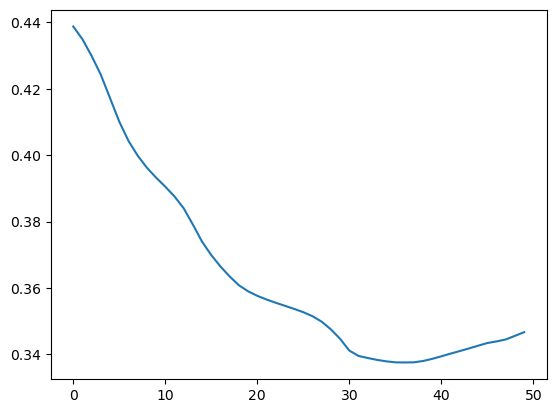

In [23]:
plt.plot(cost_list)
plt.show()

## Testing

In [24]:
total = 0
correct = 0
for prefix, y in zip(X_test, Y_test):
    next_word = generate(w1, w2, b1, prefix)
    print(next_word, y)
    print([idx2word[token] for token in prefix], '->', idx2word[next_word])
    if next_word == y:
        correct += 1
    total += 1
    
print(correct,'/',total)

14 7
['<BOS>', 'where'] -> in
14 22
['where', 'are'] -> in
14 4
['are', 'you'] -> in
14 2
['you', '?'] -> in
14 3
['?', '<EOS>'] -> in
14 17
['<BOS>', 'is'] -> in
14 14
['is', 'she'] -> in
14 16
['she', 'in'] -> in
14 4
['in', 'mexico'] -> in
14 2
['mexico', '?'] -> in
14 6
['<BOS>', 'i'] -> in
14 14
['i', 'am'] -> in
14 9
['am', 'in'] -> in
14 0
['in', 'greece'] -> in
14 2
['greece', '.'] -> in
14 15
['<BOS>', 'she'] -> in
14 14
['she', 'is'] -> in
14 16
['is', 'in'] -> in
14 0
['in', 'mexico'] -> in
14 2
['mexico', '.'] -> in
14 17
['<BOS>', 'is'] -> in
14 14
['is', 'she'] -> in
14 8
['she', 'in'] -> in
14 4
['in', 'england'] -> in
14 2
['england', '?'] -> in
4 / 25
